In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import neurogym as ngym
import logging
import warnings
from EI_network import EINet
from LeakyRNNNet import RNNNet
import torch.optim as optim
import matplotlib.pyplot as plt

c:\Users\jidon\anaconda3\envs\PyTorch\Lib\site-packages\pyparsing\core.py:23: DeprecationWarning: module 'sre_constants' is deprecated
  import sre_constants
c:\Users\jidon\anaconda3\envs\PyTorch\Lib\site-packages\gym\envs\registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(


Initalise the dataset 1

In [2]:
#Dataset loading 
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.font_manager")

# Environment
task = 'PerceptualDecisionMaking-v0'
timing = {
    'fixation': ('choice', (50, 100, 200, 400)),
    'stimulus': ('choice', (100, 200, 400, 800)),
}
kwargs = {'dt': 20, 'timing': timing}
seq_len = 100

# Make supervised dataset
dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=16,
                       seq_len=seq_len)

# A sample environment from dataset
env = dataset.env

# Network input and output size
input_size = env.observation_space.shape[0]
output_size = env.action_space.n
print_step = 2

c:\Users\jidon\anaconda3\envs\PyTorch\Lib\site-packages\gym\utils\passive_env_checker.py:69: UserWarning: WARN: Agent's minimum action space value is -infinity. This is probably too low.
  logger.warn(
c:\Users\jidon\anaconda3\envs\PyTorch\Lib\site-packages\gym\utils\passive_env_checker.py:73: UserWarning: WARN: Agent's maximum action space value is infinity. This is probably too high
  logger.warn(
c:\Users\jidon\anaconda3\envs\PyTorch\Lib\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


In [3]:
#EI net and LeakyRNN model initialisation, the number of parameter is fixed  
hidden_size = 50
e_prop = 0.8
EI_RNN = EINet(input_size=input_size, hidden_size=hidden_size,
          output_size=output_size, dt=env.dt, e_prop=e_prop, sigma_rec=0.15)
print(EI_RNN)

Leaky_RNN = RNNNet(input_size=input_size, hidden_size=hidden_size,
          output_size=output_size, dt=env.dt, e_prop=e_prop)
print(Leaky_RNN)

print("Parameters of EI_RNN:")
for name, param in EI_RNN.named_parameters():
    print(f"{name}: {param.shape}")

print("\nParameters of Leaky_RNN:")
for name, param in Leaky_RNN.named_parameters():
    print(f"{name}: {param.shape}")

EINet(
  (rnn): EIRNN(
    (input2h): Linear(in_features=3, out_features=50, bias=True)
    (h2h): EIRecLinear()
  )
  (fc): Linear(in_features=40, out_features=3, bias=True)
)
RNNNet(
  (rnn): LeakyRNN(
    (input2h): Linear(in_features=3, out_features=50, bias=True)
    (h2h): Linear(in_features=50, out_features=50, bias=True)
  )
  (fc): Linear(in_features=40, out_features=3, bias=True)
)
Parameters of EI_RNN:
rnn.input2h.weight: torch.Size([50, 3])
rnn.input2h.bias: torch.Size([50])
rnn.h2h.weight: torch.Size([50, 50])
rnn.h2h.bias: torch.Size([50])
fc.weight: torch.Size([3, 40])
fc.bias: torch.Size([3])

Parameters of Leaky_RNN:
rnn.input2h.weight: torch.Size([50, 3])
rnn.input2h.bias: torch.Size([50])
rnn.h2h.weight: torch.Size([50, 50])
rnn.h2h.bias: torch.Size([50])
fc.weight: torch.Size([3, 40])
fc.bias: torch.Size([3])


In [ ]:
import torch

EI_model_parameter = r"C:\Users\jidon\OneDrive - University of Bristol\Home Desktop\Year4\Cog AI\Coursework\model_parameter\EI_RNN_model_task3.tar"
Leaky_model_parameter = r"C:\Users\jidon\OneDrive - University of Bristol\Home Desktop\Year4\Cog AI\Coursework\model_parameter\Leaky_RNN_model_task3.tar"


EI_checkpoint = torch.load(EI_model_parameter)
Leaky_checkpoint = torch.load(Leaky_model_parameter)

def remove_prefix_from_state_dict(state_dict, prefix="base_model."):
    new_state_dict = {}
    for key, value in state_dict.items():
        if key.startswith(prefix):
            new_key = key[len(prefix):]  
        else:
            new_key = key
        new_state_dict[new_key] = value
    return new_state_dict


EI_cleaned_state_dict = remove_prefix_from_state_dict(EI_checkpoint['model_state_dict'])
Leaky_cleaned_state_dict = remove_prefix_from_state_dict(Leaky_checkpoint['model_state_dict'])

EI_RNN.load_state_dict(EI_cleaned_state_dict)
Leaky_RNN.load_state_dict(Leaky_cleaned_state_dict)


<All keys matched successfully>

In [6]:
print(EI_RNN)


print(Leaky_RNN)



EINet(
  (rnn): EIRNN(
    (input2h): Linear(in_features=3, out_features=50, bias=True)
    (h2h): EIRecLinear()
  )
  (fc): Linear(in_features=40, out_features=3, bias=True)
)
RNNNet(
  (rnn): LeakyRNN(
    (input2h): Linear(in_features=3, out_features=50, bias=True)
    (h2h): Linear(in_features=50, out_features=50, bias=True)
  )
  (fc): Linear(in_features=40, out_features=3, bias=True)
)


In [7]:
optimizer_EI_RNN = optim.Adam(EI_RNN.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
optimizer_Leaky_RNN = optim.Adam(Leaky_RNN.parameters(), lr=0.001)


Starting analysising the network 

In [ ]:
#initalise the test set basically 
env.reset(no_step=True)
env.timing.update({'fixation': ('constant', 500),
                   'stimulus': ('constant', 500)})
num_trial = 5000
#num_trial = 2
# EI_RNN net execution
ei_perf = 0
ei_activity_dict = {}
ei_trial_infos = {}
ei_stim_activity = [[], []]  
for i in range(num_trial):
    env.new_trial()
    ob, gt = env.ob, env.gt
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
    ei_action_pred, ei_rnn_activity = EI_RNN(inputs)  
    #print(ei_rnn_activity.shape)
    ei_action_pred = ei_action_pred.detach().numpy()
    ei_choice = np.argmax(ei_action_pred[-1, 0, :])
    ei_correct = ei_choice == gt[-1]

    # Log trial info for EI_RNN
    ei_trial_info = env.trial
    ei_trial_info.update({'correct': ei_correct, 'choice': ei_choice})
    ei_trial_infos[i] = ei_trial_info

    # Log stimulus period activity for EI_RNN
    
    ei_rnn_activity = ei_rnn_activity[:, 0, :].detach().numpy()
    
    ei_activity_dict[i] = ei_rnn_activity

    # Compute stimulus selectivity for EI_RNN
    ei_rnn_activity = ei_rnn_activity[env.start_ind['stimulus']: env.end_ind['stimulus']]
    ei_stim_activity[env.trial['ground_truth']].append(ei_rnn_activity)

print('Average performance for EI_RNN:', np.mean([val['correct'] for val in ei_trial_infos.values()]))


Average performance for EI_RNN: 0.844


In [ ]:
env.reset(no_step=True)
env.timing.update({'fixation': ('constant', 500),
                   'stimulus': ('constant', 500)})


leaky_perf = 0
leaky_activity_dict = {}
leaky_trial_infos = {}
leaky_stim_activity = [[], []]  
num_trial = 5000
for i in range(num_trial):
    env.new_trial()
    ob, gt = env.ob, env.gt
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
    leaky_action_pred, leaky_rnn_activity, pool_hidden_test = Leaky_RNN(inputs)  

    # Compute performance for Leaky_RNN
    leaky_action_pred = leaky_action_pred.detach().numpy()
    leaky_choice = np.argmax(leaky_action_pred[-1, 0, :])
    leaky_correct = leaky_choice == gt[-1]

    # Log trial info for Leaky_RNN
    leaky_trial_info = env.trial
    leaky_trial_info.update({'correct': leaky_correct, 'choice': leaky_choice})
    leaky_trial_infos[i] = leaky_trial_info

    # Log stimulus period activity for Leaky_RNN
    leaky_rnn_activity = leaky_rnn_activity[:, 0, :].detach().numpy()
    leaky_activity_dict[i] = leaky_rnn_activity

    # Compute stimulus selectivity for Leaky_RNN
    leaky_rnn_activity = leaky_rnn_activity[env.start_ind['stimulus']: env.end_ind['stimulus']]  
    leaky_stim_activity[env.trial['ground_truth']].append(leaky_rnn_activity)

print('Average performance for Leaky_RNN:', np.mean([val['correct'] for val in leaky_trial_infos.values()]))

Average performance for Leaky_RNN: 0.7912


Processing EI_RNN...


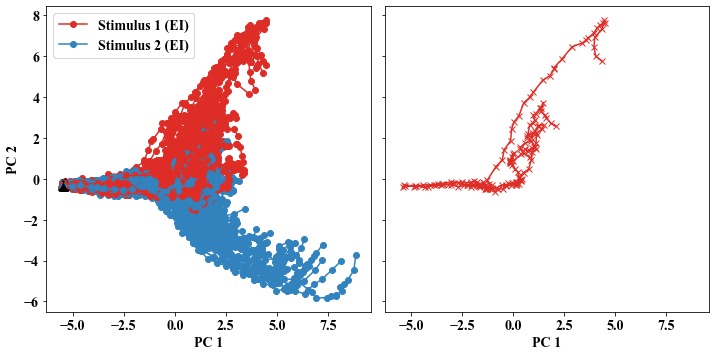

In [ ]:

from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import logging

logging.getLogger("matplotlib").setLevel(logging.CRITICAL)

num_trial = 500  
plot_until_time = 70  # Basically plot all 

print("Processing EI_RNN...")
ei_activity = np.concatenate([ei_activity_dict[i] for i in range(num_trial)], axis=0)

ei_pca = PCA(n_components=2)
ei_pca.fit(ei_activity)  
ei_activity_pc = ei_pca.transform(ei_activity)

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))

for i in range(100):
    ei_activity_pc = ei_pca.transform(ei_activity_dict[i])
    
    trial = ei_trial_infos[i]
    color = '#de2d26' if trial['ground_truth'] == 0 else '#3182bd'

    ax1.plot(ei_activity_pc[:plot_until_time, 0], ei_activity_pc[:plot_until_time, 1], 'o-', color=color, label='Stimulus 1 (EI)' if trial['ground_truth'] == 0 else 'Stimulus 2 (EI)')
    
    if i < 3:

        ax2.plot(ei_activity_pc[:plot_until_time, 0], ei_activity_pc[:plot_until_time, 1], 'x-', color=color)

    ax1.plot(ei_activity_pc[0, 0], ei_activity_pc[0, 1], '^', color='black')


handles, labels = ax1.get_legend_handles_labels()



unique_handles_labels = dict(zip(labels, handles))  

ordered_labels = ['Stimulus 1 (EI)', 'Stimulus 2 (EI)']
ordered_handles = [unique_handles_labels[label] for label in ordered_labels]

ax1.legend(ordered_handles, ordered_labels, loc='best', 
           fontsize=14, frameon=True, prop={'weight': 'bold', 'size': 14, 'family': 'Times New Roman'})



ax1.set_xlabel('PC 1', fontsize=14, fontweight='bold', fontfamily='Times New Roman')
ax1.set_ylabel('PC 2', fontsize=14, fontweight='bold', fontfamily='Times New Roman')
ax2.set_xlabel('PC 1', fontsize=14, fontweight='bold', fontfamily='Times New Roman')


plt.tight_layout()
for ax in [ax1, ax2]:
    ax.tick_params(axis='both', which='major', labelsize=14)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')
        label.set_fontfamily('Times New Roman')


save_path = r"C:\Users\jidon\OneDrive - University of Bristol\Home Desktop\Year4\Cog AI\Coursework\Pic\EI_RNN_task3_plot_bbb_PCA.png"
plt.savefig(save_path, dpi=600, bbox_inches='tight', facecolor='white', edgecolor='white')
plt.show()

Processing EI_RNN...


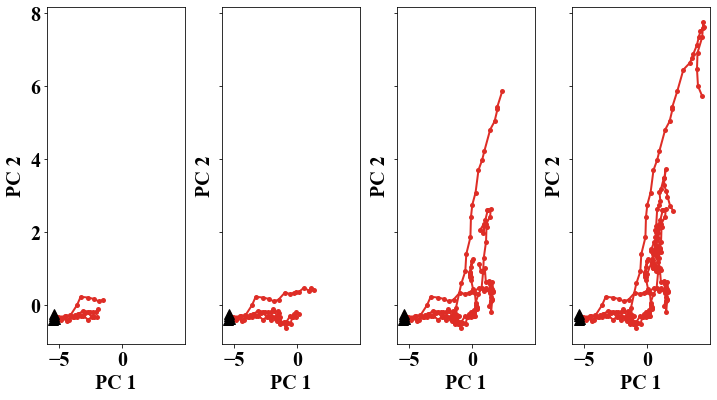

In [ ]:
import logging
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

logging.getLogger("matplotlib").setLevel(logging.CRITICAL)

num_trial = 500 
plot_until_time = 70  # Basically plot all

print("Processing EI_RNN...")
ei_activity = np.concatenate([ei_activity_dict[i] for i in range(num_trial)], axis=0)

ei_pca = PCA(n_components=2)
ei_pca.fit(ei_activity) 
ei_activity_pc = ei_pca.transform(ei_activity)

time_intervals = [10, 20, 40, plot_until_time]

fig, axs = plt.subplots(1, 4, figsize=(10, 6), sharex=True, sharey=True) 

plot_indices = [0, 1, 2, 15]

for ax, time_end in zip(axs, time_intervals):
    for i in plot_indices:  
        ei_activity_pc = ei_pca.transform(ei_activity_dict[i])

        trial = ei_trial_infos[i]
        color = '#de2d26' if trial['ground_truth'] == 0 else '#3182bd'

        ax.plot(ei_activity_pc[:time_end, 0], ei_activity_pc[:time_end, 1], 'o-', color=color, linewidth=2,markersize=2, markeredgewidth=3)
        ax.plot(ei_activity_pc[0, 0], ei_activity_pc[0, 1], '^', color='k', markersize=10)  

    ax.set_xlabel('PC 1', fontsize=20, fontweight='bold', fontfamily='Times New Roman')
    ax.set_ylabel('PC 2', fontsize=20, fontweight='bold', fontfamily='Times New Roman')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=20)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')
        label.set_fontfamily('Times New Roman')


#save_path = r"C:\Users\jidon\OneDrive - University of Bristol\Home Desktop\Year4\Cog AI\Coursework\Pic\EI_RNN_task1_plot_b_PCA.png"
#plt.savefig(save_path, dpi=600, bbox_inches='tight', facecolor='white', edgecolor='white')
#plt.show()

Processing Leaky_RNN...
Leaky_RNN Neural Activity Shape: (27500, 50)
Leaky_RNN Projected Activity Shape: (27500, 2)


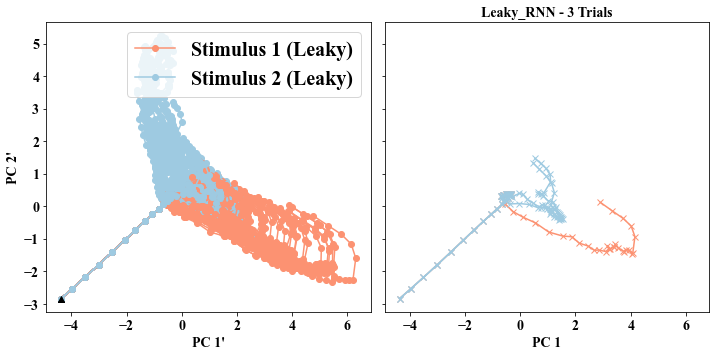

In [ ]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import logging

logging.getLogger("matplotlib").setLevel(logging.CRITICAL)

num_trial = 500 
plot_until_time = 70  # Basically plot all 

print("Processing Leaky_RNN...")
leaky_activity_all = np.concatenate([leaky_activity_dict[i] for i in range(num_trial)], axis=0)
print('Leaky_RNN Neural Activity Shape:', leaky_activity_all.shape)

leaky_pca_model = PCA(n_components=2)
leaky_pca_model.fit(leaky_activity_all)
leaky_activity_projected = leaky_pca_model.transform(leaky_activity_all)
print('Leaky_RNN Projected Activity Shape:', leaky_activity_projected.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))

for i in range(100):
    leaky_activity_per_trial = leaky_pca_model.transform(leaky_activity_dict[i])
    trial_info = leaky_trial_infos[i]
    color = '#fc9272' if trial_info['ground_truth'] == 0 else '#9ecae1'

    ax1.plot(leaky_activity_per_trial[:plot_until_time, 0], leaky_activity_per_trial[:plot_until_time, 1], 
             'o-', color=color, label='Stimulus 1 (Leaky)' if trial_info['ground_truth'] == 0 else 'Stimulus 2 (Leaky)')
    
    if i < 3:
        ax2.plot(leaky_activity_per_trial[:plot_until_time, 0], leaky_activity_per_trial[:plot_until_time, 1], 
                 'x-', color=color)

    ax1.plot(leaky_activity_per_trial[0, 0], leaky_activity_per_trial[0, 1], '^', color='black')


handles, labels = ax1.get_legend_handles_labels()

#print(unique_handles_labels.keys())
unique_handles_labels = dict(zip(labels, handles)) 
ax1.legend(unique_handles_labels.values(), unique_handles_labels.keys(), loc='best', 
           fontsize=14, frameon=True, prop={'weight': 'bold', 'size': 20, 'family': 'Times New Roman'})


ax2.set_title('Leaky_RNN - 3 Trials', fontsize=14, fontweight='bold', fontfamily='Times New Roman')
ax1.set_xlabel("PC 1'", fontsize=14, fontweight='bold', fontfamily='Times New Roman')
ax1.set_ylabel("PC 2'", fontsize=14, fontweight='bold', fontfamily='Times New Roman')
ax2.set_xlabel('PC 1', fontsize=14, fontweight='bold', fontfamily='Times New Roman')

plt.tight_layout()
for ax in [ax1, ax2]:
    ax.tick_params(axis='both', which='major', labelsize=14)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')
        label.set_fontfamily('Times New Roman')

save_path_leaky = r"C:\Users\jidon\OneDrive - University of Bristol\Home Desktop\Year4\Cog AI\Coursework\Pic\Leaky_RNN_task3_plot_bbb_PCA.png"
plt.savefig(save_path_leaky, dpi=600, bbox_inches='tight', facecolor='white', edgecolor='white')
plt.show()

Processing Leaky_RNN...


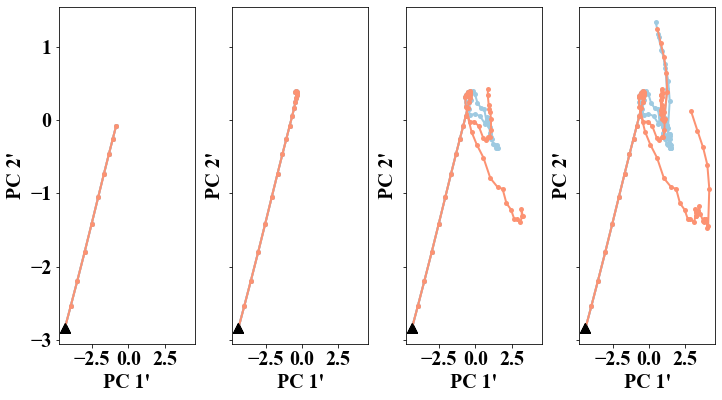

In [ ]:
logging.getLogger("matplotlib").setLevel(logging.CRITICAL)

num_trial = 500  
plot_until_time = 70  # Basically plot all

print("Processing Leaky_RNN...")
leaky_activity = np.concatenate([leaky_activity_dict[i] for i in range(num_trial)], axis=0)

leaky_pca = PCA(n_components=2)
leaky_pca.fit(leaky_activity)  
leaky_activity_pc = leaky_pca.transform(leaky_activity)

time_intervals = [10, 20, 40, plot_until_time]

fig, axs = plt.subplots(1, 4, figsize=(10, 6), sharex=True, sharey=True)  

#plot_indices = [0, 1, 4, 15]
plot_indices = [0,1,4,5] #the plot indcies 


for ax, time_end in zip(axs, time_intervals):
    for i in plot_indices:  
        leaky_activity_pc = leaky_pca.transform(leaky_activity_dict[i])

        trial = leaky_trial_infos[i]
        color = '#fc9272' if trial['ground_truth'] == 0 else '#9ecae1' 

        ax.plot(leaky_activity_pc[:time_end, 0], leaky_activity_pc[:time_end, 1], 
                'o-', color=color, linewidth=2,markersize=2, markeredgewidth=3)  


        ax.plot(leaky_activity_pc[0, 0], leaky_activity_pc[0, 1], '^', color='k', markersize=10)

    ax.set_xlabel("PC 1'", fontsize=20, fontweight='bold', fontfamily='Times New Roman')
    ax.set_ylabel("PC 2'", fontsize=20, fontweight='bold', fontfamily='Times New Roman')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=20)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')
        label.set_fontfamily('Times New Roman')


#save_path_leaky = r"C:\Users\jidon\OneDrive - University of Bristol\Home Desktop\Year4\Cog AI\Coursework\Pic\Leaky_RNN_task1_plot_b_PCA.png"
#plt.savefig(save_path_leaky, dpi=600, bbox_inches='tight', facecolor='white', edgecolor='white')
#plt.show()

Lesioning the network

In [ ]:
#for EI
e_size = EI_RNN.rnn.e_size  

mean_activity = []
std_activity = []
for ground_truth in [0, 1]:
    activity = np.concatenate(ei_stim_activity[ground_truth], axis=0)
    print(activity.shape)
    mean_activity.append(np.mean(activity, axis=0)) 
    std_activity.append(np.std(activity, axis=0))

# Compute d'
selectivity = (mean_activity[0] - mean_activity[1])
selectivity /= np.sqrt((std_activity[0]**2 + std_activity[1]**2 + 1e-7) / 2)

# Sort index for selectivity, separately for E and I
ind_sort = np.concatenate((np.argsort(selectivity[:e_size]),
                           np.argsort(selectivity[e_size:]) + e_size)) # adding e_size to make the selection in the absolute frame of reference 

# Define a threshold to identify top contributing neurons (e.g., top 20% based on selectivity)
lesion_fraction = 0.2

num_neurons_to_lesion = int(lesion_fraction * EI_RNN.rnn.hidden_size)  # Lesion top 20% most selective neurons
selective_neurons = np.argsort(np.abs(selectivity))[-num_neurons_to_lesion:]  # Indices of most selective neurons


def lesion_network(net, selective_neurons):
    with torch.no_grad(): 
        net.rnn.h2h.weight[selective_neurons, :] = 0
        net.rnn.h2h.weight[:, selective_neurons] = 0

initial_weights = EI_RNN.rnn.h2h.weight.clone()


lesion_network(EI_RNN, selective_neurons)

loss_values_lesioned = []  
running_loss_lesioned = 0.0

print('Evaluating EI_RNN after lesioning top 20% of neurons...')
for i in range(300): 
    inputs, labels = dataset() 
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels.flatten()).type(torch.long)

    # Zero the gradient buffers
    optimizer_EI_RNN.zero_grad()

    # Forward pass
    output, activity = EI_RNN(inputs)
    output = output.view(-1, output_size)

    # Compute loss
    loss = criterion(output, labels)  

    # Update running loss
    running_loss_lesioned += loss.item()
    if i % print_step == (print_step - 1): 
        average_loss = running_loss_lesioned / print_step
        print('Step {}, Lesioned Network Loss {:0.4f}'.format(i + 1, average_loss))
        loss_values_lesioned.append(average_loss)
        running_loss_lesioned = 0.0


EI_RNN.rnn.h2h.weight = nn.Parameter(initial_weights)
#print(selective_neurons)

(61325, 50)
(63675, 50)
Evaluating EI_RNN after lesioning top 20% of neurons...
Step 2, Lesioned Network Loss 0.3150
Step 4, Lesioned Network Loss 0.3192
Step 6, Lesioned Network Loss 0.2848
Step 8, Lesioned Network Loss 0.3178
Step 10, Lesioned Network Loss 0.3146
Step 12, Lesioned Network Loss 0.2777
Step 14, Lesioned Network Loss 0.3156
Step 16, Lesioned Network Loss 0.2930
Step 18, Lesioned Network Loss 0.3289
Step 20, Lesioned Network Loss 0.2988
Step 22, Lesioned Network Loss 0.3029
Step 24, Lesioned Network Loss 0.2779
Step 26, Lesioned Network Loss 0.2979
Step 28, Lesioned Network Loss 0.3036
Step 30, Lesioned Network Loss 0.2948
Step 32, Lesioned Network Loss 0.2838
Step 34, Lesioned Network Loss 0.3281
Step 36, Lesioned Network Loss 0.3253
Step 38, Lesioned Network Loss 0.3130
Step 40, Lesioned Network Loss 0.3036
Step 42, Lesioned Network Loss 0.3209
Step 44, Lesioned Network Loss 0.3158
Step 46, Lesioned Network Loss 0.2877
Step 48, Lesioned Network Loss 0.3130
Step 50, Les

###Fix point 

In [ ]:
import sys
sys.path.append(r"C:\Users\jidon\OneDrive - University of Bristol\Home Desktop\Year4\Cog AI\Coursework\fixed-point-finder")


from FixedPointFinderTorch import FixedPointFinderTorch as FixedPointFinder
import torch

In [ ]:

class FixedPointRNNWrapper(torch.nn.Module):
    def __init__(self, rnn, batch_first=False):
        super(FixedPointRNNWrapper, self).__init__()
        self.rnn = rnn
        self.batch_first = batch_first  
        #print(batch_first.shape)

    def forward(self, input, hidden):
 
        hidden = hidden.squeeze(0)

        output, hidden = self.rnn(input, hidden)

        hidden = hidden.unsqueeze(0)

        return None, hidden

In [ ]:
# For the EI net 

rnn_model_fixed_point = FixedPointRNNWrapper(EI_RNN.rnn, batch_first=False)

finder = FixedPointFinder(rnn_model_fixed_point)

initial_conditions = torch.randn(100, EI_RNN.rnn.hidden_size)  
print(initial_conditions.shape)
inputs = torch.zeros(100, EI_RNN.rnn.input_size)  
print(inputs.shape)

init_hidden_np = initial_conditions.cpu().numpy()
inputs_np = inputs.cpu().numpy()

fixed_points_result = finder.find_fixed_points(initial_states=init_hidden_np, inputs=inputs_np)

fps = fixed_points_result[0]  

fixed_points = fps.xstar  

torch.Size([100, 50])
torch.Size([100, 3])

Searching for fixed points from 100 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
	Maximum iteration count reached. Terminating.
		5000 iters
		q = 1.79e-01 +/- 3.81e-02
		dq = 4.11e-02 +/- 2.99e-02
		learning rate = 1.97e-07
		avg iter time = 1.06e-03 sec
	Identified 100 unique fixed points.
		initial_states: 0 outliers detected (of 100).
		fixed points: 0 outliers detected (of 100).
	Computing recurrent Jacobian at 100 unique fixed points.
	Computing input Jacobian at 100 unique fixed points.
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.
	Fixed point finding complete.



(275000, 50)
(100, 50)


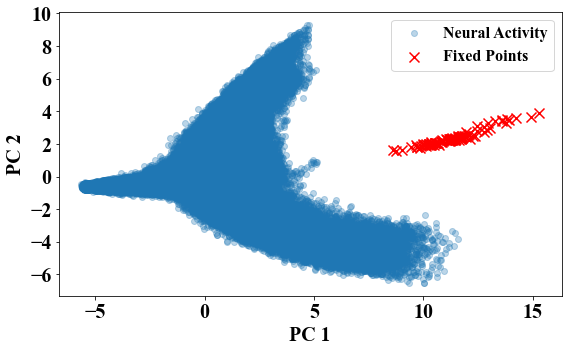

In [ ]:
activity_list = []
for trial_activity in ei_activity_dict.values():
    activity_list.append(trial_activity)  
activity = np.vstack(activity_list) 

fixed_points_array = np.vstack(fixed_points)  


from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)

activity_and_fp = np.concatenate([activity, fixed_points_array], axis=0) 
pca.fit(activity_and_fp)
print(activity.shape)
print(fixed_points_array.shape)

activity_pc = pca.transform(activity)
fixed_points_pc = pca.transform(fixed_points_array)

plt.figure(figsize=(8, 5))
plt.scatter(activity_pc[:, 0], activity_pc[:, 1], alpha=0.3, label='Neural Activity')
plt.scatter(fixed_points_pc[:, 0], fixed_points_pc[:, 1], color='red', marker='x', s=100, label='Fixed Points')


plt.xlabel("PC 1", fontsize=20, fontweight='bold', fontfamily='Times New Roman')
plt.ylabel("PC 2", fontsize=20, fontweight='bold', fontfamily='Times New Roman')

plt.legend(
    prop={
        'size': 16, 
        'weight': 'bold',
        'family': 'Times New Roman'
    },
    loc='best'  
)

plt.xticks(fontsize=20, fontweight='bold', fontfamily='Times New Roman')
plt.yticks(fontsize=20, fontweight='bold', fontfamily='Times New Roman')

save_path_leaky = r"C:\Users\jidon\OneDrive - University of Bristol\Home Desktop\Year4\Cog AI\Coursework\Pic\EI_RNN_task3_plot_fp_PCA_bbb.png"
plt.tight_layout()
plt.savefig(save_path_leaky, dpi=600, bbox_inches='tight', facecolor='white', edgecolor='white')

plt.show()


Searching for fixed points from 100 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
	Maximum iteration count reached. Terminating.
		5000 iters
		q = 2.08e-01 +/- 5.26e-02
		dq = 5.95e-02 +/- 4.47e-02
		learning rate = 1.97e-07
		avg iter time = 1.11e-03 sec
	Identified 100 unique fixed points.
		initial_states: 0 outliers detected (of 100).
		fixed points: 0 outliers detected (of 100).
	Computing recurrent Jacobian at 100 unique fixed points.
	Computing input Jacobian at 100 unique fixed points.
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.
	Fixed point finding complete.


Searching for fixed points from 100 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
	Maximum iteration count reached. Terminating.
		5000 iters
		q = 1.77e-01 +/- 3.98e-02
		dq = 4.36e-02 +/- 3.30

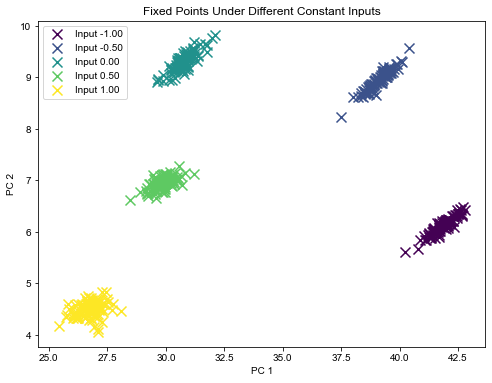

In [ ]:
input_values = np.linspace(-1, 1, 5) 
fixed_points_by_input = []

for input_val in input_values:

    inputs_np = np.full((100, EI_RNN.input_size), input_val)  

    init_hidden_np = initial_conditions.cpu().numpy()

    fps_result = finder.find_fixed_points(initial_states=init_hidden_np, inputs=inputs_np)
    fps = fps_result[0]
    fixed_points_by_input.append((input_val, fps.xstar))


plt.figure(figsize=(8, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(input_values)))

for idx, (input_val, fp_array) in enumerate(fixed_points_by_input):
    fp_pc = pca.transform(fp_array)
    plt.scatter(fp_pc[:, 0], fp_pc[:, 1], color=colors[idx], marker='x', s=100, label=f'Input {input_val:.2f}')

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Fixed Points Under Different Constant Inputs')
plt.legend()
plt.show()


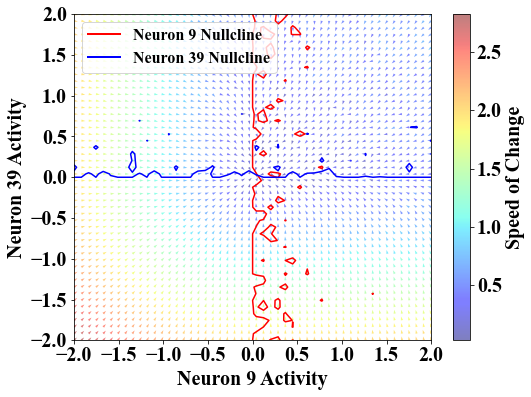

In [ ]:
from matplotlib.lines import Line2D
selectivity_indices = np.argsort(np.abs(selectivity))[-2:]
neuron1, neuron2 = selectivity_indices

n_points = 50
state_range = np.linspace(-2, 2, n_points)
neuron1_states, neuron2_states = np.meshgrid(state_range, state_range)

grid_states = np.c_[neuron1_states.ravel(), neuron2_states.ravel()]

inputs = torch.zeros(grid_states.shape[0], EI_RNN.input_size).type(torch.float32)

initial_states = np.zeros((grid_states.shape[0], EI_RNN.rnn.hidden_size))
initial_states[:, neuron1] = grid_states[:, 0]
initial_states[:, neuron2] = grid_states[:, 1]

initial_states_tensor = torch.from_numpy(initial_states).type(torch.float32)

_, next_states = EI_RNN.rnn(inputs.unsqueeze(0), initial_states_tensor)
next_states = next_states.detach().cpu().numpy()

d_neuron1 = next_states[:, neuron1] - initial_states[:, neuron1]
d_neuron2 = next_states[:, neuron2] - initial_states[:, neuron2]

d_neuron1_grid = d_neuron1.reshape(neuron1_states.shape)
d_neuron2_grid = d_neuron2.reshape(neuron2_states.shape)

U = d_neuron1_grid  
V = d_neuron2_grid  

speed = np.sqrt(U**2 + V**2)
U_norm = U / speed
V_norm = V / speed

plt.figure(figsize=(8, 6))
plt.contour(neuron1_states, neuron2_states, d_neuron1_grid, levels=[0], colors='red')
plt.contour(neuron1_states, neuron2_states, d_neuron2_grid, levels=[0], colors='blue')
quiver = plt.quiver(neuron1_states, neuron2_states, U_norm, V_norm, speed, cmap='jet', alpha=0.5)

legend_elements = [Line2D([0], [0], color='red', lw=2, label=f'Neuron {neuron1} Nullcline'),
                   Line2D([0], [0], color='blue', lw=2, label=f'Neuron {neuron2} Nullcline')]

plt.legend(
    handles=legend_elements,
    loc='upper left',  
    prop={
        'size': 16, 
        'weight': 'bold',
        'family': 'Times New Roman'
    }
)


plt.xlabel(f'Neuron {neuron1} Activity', fontsize=20, fontweight='bold', fontfamily='Times New Roman')
plt.ylabel(f'Neuron {neuron2} Activity', fontsize=20, fontweight='bold', fontfamily='Times New Roman')

plt.xticks(fontsize=20, fontweight='bold', fontfamily='Times New Roman')
plt.yticks(fontsize=20, fontweight='bold', fontfamily='Times New Roman')

cbar = plt.colorbar(quiver)
cbar.set_label('Speed of Change', fontsize=20, fontweight='bold', fontfamily='Times New Roman')
cbar.ax.tick_params(labelsize=20)
for label in cbar.ax.get_yticklabels():
    label.set_fontweight('bold')
    label.set_fontfamily('Times New Roman')

#save_path_leaky = r"C:\Users\jidon\OneDrive - University of Bristol\Home Desktop\Year4\Cog AI\Coursework\Pic\EI_RNN_task1_plot_nuclines.png"
#plt.tight_layout()
#plt.savefig(save_path_leaky, dpi=600, bbox_inches='tight', facecolor='white', edgecolor='white')

plt.show()

In [38]:
print(neuron1, neuron2)
print(selectivity)

9 39
[-0.40339586  0.3522393  -1.3817316   0.62477255 -1.46601    -1.2323942
 -1.175715    1.3279551  -0.5351932  -1.4833856   0.44570774  1.3640112
  1.0052906  -1.0441728  -1.1458837  -0.02538008 -0.18776098  0.7548152
 -0.2756603   1.3241142  -1.047181    0.90304375  0.9722592  -0.5190819
  1.3683932  -1.4477253  -1.2648278   0.9281659   0.9112977   1.0180968
 -1.3862569   0.02041813  0.9289101   0.00568507  0.9628948  -0.05998545
  1.4204783  -1.2613949  -0.37843394  1.4868969  -0.10951351  0.57603514
 -0.928142    0.22306503 -1.3948333  -0.7796774   0.74621916 -1.3420334
  1.3134176   0.05466426]


In [ ]:
#for leaky RNN lession
e_size_Leaky_RNN = Leaky_RNN.e_size  

mean_activity = []
std_activity = []
for ground_truth in [0, 1]:
    activity = np.concatenate(leaky_stim_activity[ground_truth], axis=0)
    print(activity.shape)
    mean_activity.append(np.mean(activity, axis=0))
    std_activity.append(np.std(activity, axis=0))

# Compute d'
selectivity = (mean_activity[0] - mean_activity[1])
selectivity /= np.sqrt((std_activity[0]**2 + std_activity[1]**2 + 1e-7) / 2)

# Sort index for selectivity, separately for E and I
ind_sort = np.concatenate((np.argsort(selectivity[:e_size]),
                           np.argsort(selectivity[e_size:]) + e_size))

# Define a threshold to identify top contributing neurons (e.g., top 20% based on selectivity)
lesion_fraction = 0.2

num_neurons_to_lesion = int(lesion_fraction * Leaky_RNN.rnn.hidden_size)  # Lesion top 20% most selective neurons
selective_neurons = np.argsort(np.abs(selectivity))[-num_neurons_to_lesion:]  # Indices of most selective neurons

def lesion_network(net, selective_neurons):
    with torch.no_grad():  
        net.rnn.h2h.weight[selective_neurons, :] = 0
        net.rnn.h2h.weight[:, selective_neurons] = 0


initial_weights = Leaky_RNN.rnn.h2h.weight.clone()

lesion_network(Leaky_RNN, selective_neurons)

loss_values_lesioned = []  
running_loss_lesioned = 0.0

print('Evaluating Leaky_RNN after lesioning top 20% of neurons...')
for i in range(300): 
    inputs, labels = dataset()  
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels.flatten()).type(torch.long)

    optimizer_Leaky_RNN.zero_grad()

    output, activity,_ = Leaky_RNN(inputs)
    output = output.view(-1, output_size)

    loss = criterion(output, labels) 

    # Update running loss
    running_loss_lesioned += loss.item()
    if i % print_step == (print_step - 1):  
        average_loss = running_loss_lesioned / print_step
        print('Step {}, Lesioned Network Loss {:0.4f}'.format(i + 1, average_loss))
        loss_values_lesioned.append(average_loss)
        running_loss_lesioned = 0.0

Leaky_RNN.rnn.h2h.weight = nn.Parameter(initial_weights)

(63825, 50)
(61175, 50)
Evaluating Leaky_RNN after lesioning top 20% of neurons...
Step 2, Lesioned Network Loss 0.1289
Step 4, Lesioned Network Loss 0.1836
Step 6, Lesioned Network Loss 0.1785
Step 8, Lesioned Network Loss 0.1523
Step 10, Lesioned Network Loss 0.1501
Step 12, Lesioned Network Loss 0.1391
Step 14, Lesioned Network Loss 0.1548
Step 16, Lesioned Network Loss 0.1422
Step 18, Lesioned Network Loss 0.1486
Step 20, Lesioned Network Loss 0.1464
Step 22, Lesioned Network Loss 0.1703
Step 24, Lesioned Network Loss 0.1402
Step 26, Lesioned Network Loss 0.1745
Step 28, Lesioned Network Loss 0.1466
Step 30, Lesioned Network Loss 0.1612
Step 32, Lesioned Network Loss 0.1349
Step 34, Lesioned Network Loss 0.1516
Step 36, Lesioned Network Loss 0.1603
Step 38, Lesioned Network Loss 0.1587
Step 40, Lesioned Network Loss 0.1548
Step 42, Lesioned Network Loss 0.1560
Step 44, Lesioned Network Loss 0.1336
Step 46, Lesioned Network Loss 0.1290
Step 48, Lesioned Network Loss 0.1859
Step 50, 

In [ ]:
#do it for the leaky RNN

Leaky_rnn_model_fixed_point = FixedPointRNNWrapper(Leaky_RNN.rnn, batch_first=False)

leaky_finder = FixedPointFinder(Leaky_rnn_model_fixed_point) 

initial_conditions = torch.randn(100, Leaky_RNN.rnn.hidden_size)  
print(initial_conditions.shape)
inputs = torch.zeros(100, Leaky_RNN.rnn.input_size)  
print(inputs.shape)

init_hidden_np = initial_conditions.cpu().numpy()
inputs_np = inputs.cpu().numpy()

fixed_points_result = leaky_finder.find_fixed_points(initial_states=init_hidden_np, inputs=inputs_np)

fps = fixed_points_result[0] 

fixed_points = fps.xstar 


torch.Size([100, 50])
torch.Size([100, 3])

Searching for fixed points from 100 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
	Optimization complete to desired tolerance.
		991 iters
		q = 8.74e-14 +/- 1.08e-13
		dq = 2.92e-14 +/- 3.21e-14
		learning rate = 9.45e-02
		avg iter time = 8.79e-04 sec
	Identified 1 unique fixed points.
		initial_states: 0 outliers detected (of 100).
		fixed points: 0 outliers detected (of 1).
	Computing recurrent Jacobian at 1 unique fixed points.
	Computing input Jacobian at 1 unique fixed points.
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.
	Fixed point finding complete.



(1, 50)
(275000, 50)
(1, 50)


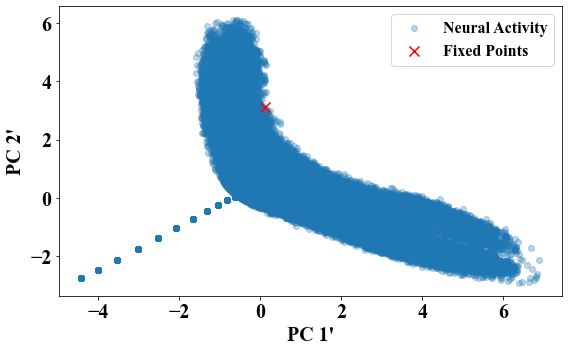

In [ ]:
activity_list = []
for trial_activity in leaky_activity_dict.values():
    activity_list.append(trial_activity)  
activity = np.vstack(activity_list) 

fixed_points_array = np.vstack(fixed_points) 

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)

activity_and_fp = np.concatenate([activity, fixed_points_array], axis=0) 

print(fixed_points_array.shape)

pca.fit(activity_and_fp)
print(activity.shape)
print(fixed_points_array.shape)

activity_pc = pca.transform(activity)
fixed_points_pc = pca.transform(fixed_points_array)

plt.figure(figsize=(8, 5))
plt.scatter(activity_pc[:, 0], activity_pc[:, 1], alpha=0.3, label='Neural Activity')
plt.scatter(fixed_points_pc[:, 0], fixed_points_pc[:, 1], color='red', marker='x', s=100, label='Fixed Points')


plt.xlabel("PC 1'", fontsize=20, fontweight='bold', fontfamily='Times New Roman')
plt.ylabel("PC 2'", fontsize=20, fontweight='bold', fontfamily='Times New Roman')

plt.legend(
    prop={
        'size': 16,
        'weight': 'bold',
        'family': 'Times New Roman'
    },
    loc='best'
)


plt.xticks(fontsize=20, fontweight='bold', fontfamily='Times New Roman')
plt.yticks(fontsize=20, fontweight='bold', fontfamily='Times New Roman')


save_path_leaky = r"C:\Users\jidon\OneDrive - University of Bristol\Home Desktop\Year4\Cog AI\Coursework\Pic\Leaky_RNN_task3_plot_fp_PCA_bbb.png"
plt.tight_layout()
plt.savefig(save_path_leaky, dpi=600, bbox_inches='tight', facecolor='white', edgecolor='white')

plt.show()


Searching for fixed points from 100 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
	Optimization complete to desired tolerance.
		728 iters
		q = 5.01e-13 +/- 2.00e-13
		dq = 1.70e-13 +/- 1.44e-13
		learning rate = 1.75e-01
		avg iter time = 1.14e-03 sec
	Identified 1 unique fixed points.
		initial_states: 0 outliers detected (of 100).
		fixed points: 0 outliers detected (of 1).
	Computing recurrent Jacobian at 1 unique fixed points.
	Computing input Jacobian at 1 unique fixed points.
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.
	Fixed point finding complete.


Searching for fixed points from 100 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
	Optimization complete to desired tolerance.
		1131 iters
		q = 6.01e-13 +/- 1.58e-13
		dq = 1.51e-13 +/- 1.25e-13
		learni

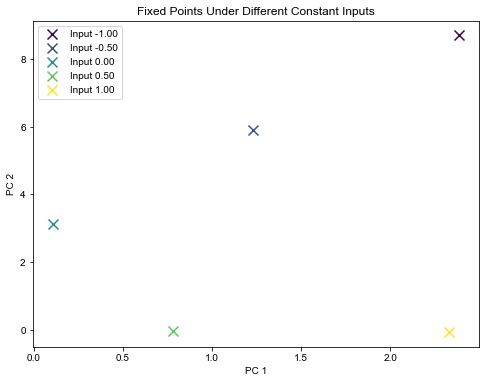

In [ ]:

input_values = np.linspace(-1, 1, 5)  
fixed_points_by_input = []

for input_val in input_values:

    inputs_np = np.full((100, EI_RNN.input_size), input_val)  

    init_hidden_np = initial_conditions.cpu().numpy()

    fps_result = leaky_finder.find_fixed_points(initial_states=init_hidden_np, inputs=inputs_np)
    fps = fps_result[0]
    fixed_points_by_input.append((input_val, fps.xstar))

plt.figure(figsize=(8, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(input_values)))

for idx, (input_val, fp_array) in enumerate(fixed_points_by_input): 
    fp_pc = pca.transform(fp_array)
    plt.scatter(fp_pc[:, 0], fp_pc[:, 1], color=colors[idx], marker='x', s=100, label=f'Input {input_val:.2f}')

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Fixed Points Under Different Constant Inputs')
plt.legend()
plt.show()

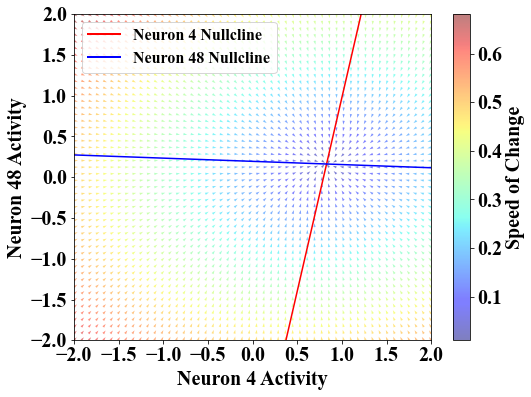

In [43]:
from matplotlib.lines import Line2D
from matplotlib.font_manager import FontProperties

selectivity_indices = np.argsort(np.abs(selectivity))[-2:]
neuron1, neuron2 = selectivity_indices

n_points = 50
state_range = np.linspace(-2, 2, n_points)
neuron1_states, neuron2_states = np.meshgrid(state_range, state_range)

grid_states = np.c_[neuron1_states.ravel(), neuron2_states.ravel()]

inputs = torch.zeros(grid_states.shape[0], EI_RNN.input_size).type(torch.float32)


initial_states = np.zeros((grid_states.shape[0], EI_RNN.rnn.hidden_size))
initial_states[:, neuron1] = grid_states[:, 0]
initial_states[:, neuron2] = grid_states[:, 1]


initial_states_tensor = torch.from_numpy(initial_states).type(torch.float32)


_, next_states = Leaky_RNN.rnn(inputs.unsqueeze(0), initial_states_tensor)
next_states = next_states.detach().cpu().numpy()


d_neuron1 = next_states[:, neuron1] - initial_states[:, neuron1]
d_neuron2 = next_states[:, neuron2] - initial_states[:, neuron2]


d_neuron1_grid = d_neuron1.reshape(neuron1_states.shape)
d_neuron2_grid = d_neuron2.reshape(neuron2_states.shape)


U = d_neuron1_grid  
V = d_neuron2_grid  

speed = np.sqrt(U**2 + V**2)
U_norm = U / speed
V_norm = V / speed


plt.figure(figsize=(8, 6))
plt.contour(neuron1_states, neuron2_states, d_neuron1_grid, levels=[0], colors='red')
plt.contour(neuron1_states, neuron2_states, d_neuron2_grid, levels=[0], colors='blue')
quiver = plt.quiver(neuron1_states, neuron2_states, U_norm, V_norm, speed, cmap='jet', alpha=0.5)


legend_elements = [
    Line2D([0], [0], color='red', lw=2, label=f'Neuron {neuron1} Nullcline'),
    Line2D([0], [0], color='blue', lw=2, label=f'Neuron {neuron2} Nullcline')
]


plt.legend(
    handles=legend_elements,
    loc='upper left',
    prop={
        'size': 16,  
        'weight': 'bold',
        'family': 'Times New Roman'
    }
)


plt.xlabel(f'Neuron {neuron1} Activity', fontsize=20, fontweight='bold', fontfamily='Times New Roman')
plt.ylabel(f'Neuron {neuron2} Activity', fontsize=20, fontweight='bold', fontfamily='Times New Roman')


plt.xticks(fontsize=20, fontweight='bold', fontfamily='Times New Roman')
plt.yticks(fontsize=20, fontweight='bold', fontfamily='Times New Roman')


cbar = plt.colorbar(quiver)
cbar.set_label('Speed of Change', fontsize=20, fontweight='bold', fontfamily='Times New Roman')
cbar.ax.tick_params(labelsize=20)
for label in cbar.ax.get_yticklabels():
    label.set_fontweight('bold')
    label.set_fontfamily('Times New Roman')

#save_path_leaky = r"C:\Users\jidon\OneDrive - University of Bristol\Home Desktop\Year4\Cog AI\Coursework\Pic\Leaky_RNN_task1_plot_nuclines.png"
#plt.tight_layout()
#plt.savefig(save_path_leaky, dpi=600, bbox_inches='tight', facecolor='white', edgecolor='white')

plt.show()

In [44]:
print(neuron1, neuron2)
print(selectivity)

4 48
[ 4.79977190e-01  1.37493646e+00  0.00000000e+00  7.62957096e-01
  1.71946084e+00 -1.29138732e+00 -1.24174690e+00 -1.26371397e-05
  1.59293950e+00  1.34725380e+00  1.51707649e+00  1.43336344e+00
  1.26903534e+00  1.18072093e+00  1.68988109e+00  0.00000000e+00
  1.26204336e+00  1.57611215e+00 -7.23246992e-01  1.61626768e+00
 -1.02318265e-01 -1.46860015e+00 -6.99739575e-01  0.00000000e+00
  0.00000000e+00  1.42172742e+00  1.52461696e-02  1.55449283e+00
  0.00000000e+00 -1.27809560e+00  6.86706483e-01 -8.12416136e-01
 -1.42112005e+00 -6.26372516e-01 -3.80693376e-01 -1.41984689e+00
  5.68130732e-01 -1.38811922e+00 -1.43405056e+00 -1.38321832e-01
  2.83689141e-01 -1.30545866e+00 -2.71333784e-01 -1.42713463e+00
  0.00000000e+00 -2.19302177e-01 -1.55485320e+00  0.00000000e+00
  1.75008607e+00  0.00000000e+00]
